In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Train ResNet 18

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

IMG_SIZE = 224
data_dir = "/content/drive/MyDrive/Cropped_Microbes/train"

# Transformations
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model
num_classes = len(dataset.classes)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Loss: 1.2137
Epoch [2/30], Loss: 1.0493
Epoch [3/30], Loss: 0.8829
Epoch [4/30], Loss: 0.5957
Epoch [5/30], Loss: 0.6370
Epoch [6/30], Loss: 0.5583
Epoch [7/30], Loss: 0.4379
Epoch [8/30], Loss: 0.3436
Epoch [9/30], Loss: 0.4004
Epoch [10/30], Loss: 0.3551
Epoch [11/30], Loss: 0.3229
Epoch [12/30], Loss: 0.1927
Epoch [13/30], Loss: 0.1896
Epoch [14/30], Loss: 0.1829
Epoch [15/30], Loss: 0.2001
Epoch [16/30], Loss: 0.1721
Epoch [17/30], Loss: 0.2651
Epoch [18/30], Loss: 0.3308
Epoch [19/30], Loss: 0.3028
Epoch [20/30], Loss: 0.2630
Epoch [21/30], Loss: 0.2677
Epoch [22/30], Loss: 0.2588
Epoch [23/30], Loss: 0.1201
Epoch [24/30], Loss: 0.0569
Epoch [25/30], Loss: 0.0674
Epoch [26/30], Loss: 0.0343
Epoch [27/30], Loss: 0.0290
Epoch [28/30], Loss: 0.0393
Epoch [29/30], Loss: 0.0885
Epoch [30/30], Loss: 0.0502


Model Evaluation

In [ ]:
# Evaluation
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Validation Accuracy: 86.02%


                    precision    recall  f1-score   support

            Amoeba       0.75      0.71      0.73        17
        Microalgae       0.78      0.82      0.80        17
          Nematode       0.85      0.58      0.69        19
      Rod bacteria       0.97      1.00      0.98        56
           Rotifer       0.79      1.00      0.88        11
Spherical bacteria       0.93      0.93      0.93        28
   Spiral bacteria       0.57      0.67      0.62        18
             Yeast       1.00      0.90      0.95        20

          accuracy                           0.86       186
         macro avg       0.83      0.83      0.82       186
      weighted avg       0.87      0.86      0.86       186



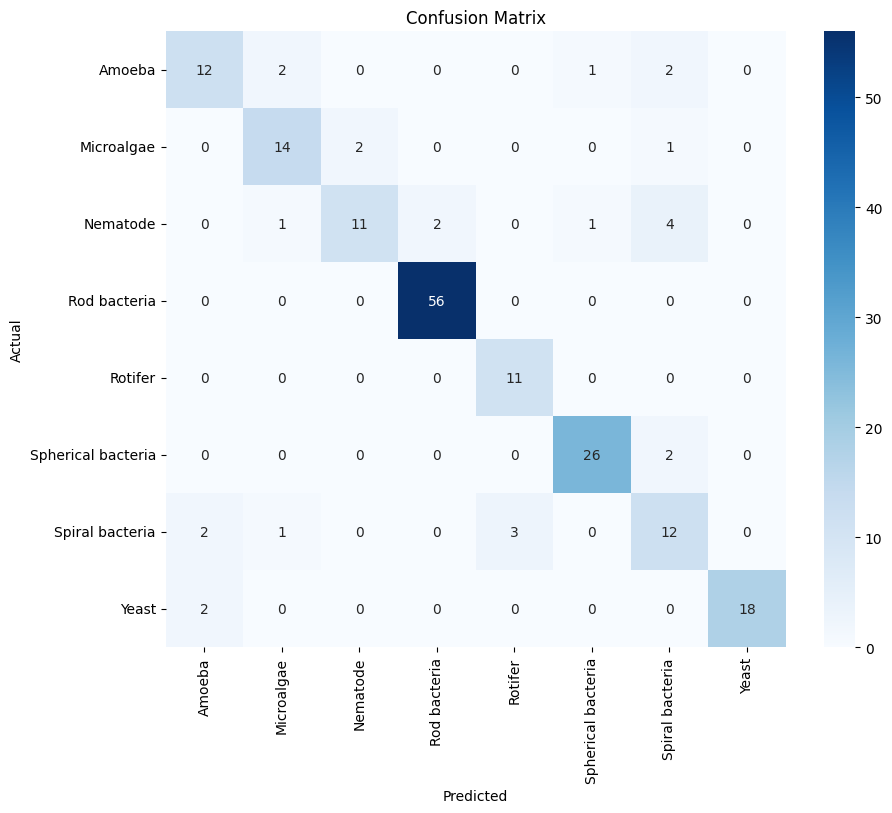

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
class_names = dataset.classes

print(classification_report(all_labels, all_preds, target_names=class_names))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()